## Predicting cyclist traffic in Paris

## Introduction

The dataset was collected with cyclist counters installed by Paris city council in multiple locations. It contains hourly information about cyclist traffic, as well as the following features,
 - counter name
 - counter site name
 - date
 - counter installation date
 - latitude and longitude
 
Available features are quite scarce. However, **we can also use any external data that can help us to predict the target variable.** 

Our notebook is organised as so, and we try to have a look at the data before jumping into model selection.

Introduction EDA
Look at top Station
Temporal Analysis:
- Seasonal look (Overview)
- Rush Hours
- Weekdays and Week-ends
- Bank Holidays vs working days
- School Holidays (vacances scolaires) and working days

The idea of using Ridge was to use a model where less important parameters are squished to see which parameters are really important, we then are going to use them with a RandomForest. Why a RF will be explained later in this notebook.
Model Selection:
- Trying out a simple Ridge regression with feature engineering on temporal data (hours_cos is a good predictor)
- Gridsearch and Hyperparameters selection for Ridge
- Adding weather data
- Ridge Limitations
- Trying out RandomForest

Let's start by a really quick EDA, then we'll think about adding potentially relevent external data points to enrich our analysis.

## Exploratory Data Analysis

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import sklearn
import datetime
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tpot import TPOTClassifier
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from flaml import AutoML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from tpot import TPOTRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
from tpot import TPOTRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import optuna

c:\Users\cleme\anaconda3\envs\env-conda\Lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [2]:
df = pd.read_parquet(Path("data")/ "train.parquet")
df.head()

counter_id              counter_name    site_id  \
48321  100007049-102007049  28 boulevard Diderot E-O  100007049   
48324  100007049-102007049  28 boulevard Diderot E-O  100007049   
48327  100007049-102007049  28 boulevard Diderot E-O  100007049   
48330  100007049-102007049  28 boulevard Diderot E-O  100007049   
48333  100007049-102007049  28 boulevard Diderot E-O  100007049   

                  site_name  bike_count                date  \
48321  28 boulevard Diderot         0.0 2020-09-01 02:00:00   
48324  28 boulevard Diderot         1.0 2020-09-01 03:00:00   
48327  28 boulevard Diderot         0.0 2020-09-01 04:00:00   
48330  28 boulevard Diderot         4.0 2020-09-01 15:00:00   
48333  28 boulevard Diderot         9.0 2020-09-01 18:00:00   

      counter_installation_date         coordinates counter_technical_id  \
48321                2013-01-18  48.846028,2.375429          Y2H15027244   
48324                2013-01-18  48.846028,2.375429          Y2H15027244   
48327                2013-01-18  48.846028,2.375429          Y2H15027244   
48330                2013-01-18  48.846028,2.375429          Y2H15027244   
48333                2013-01-18  48.846028,2.375429          Y2H15027244   

        latitude  longitude  log_bike_count  
48321  48.846028   2.375429        0.000000  
48324  48.846028   2.375429        0.693147  
48327  48.846028   2.375429        0.000000  
48330  48.846028   2.375429        1.609438  
48333  48.846028   2.375429        2.302585

In [10]:
#  Basic Overview
print("=== Basic Information ===")
print(df.info())
print("\n=== First few rows ===")
print(df.head())
print("\n=== Basic Statistics ===")
print(df.describe())

=== Basic Information ===
<class 'pandas.core.frame.DataFrame'>
Index: 496827 entries, 48321 to 929187
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 496827 non-null  category      
 1   counter_name               496827 non-null  category      
 2   site_id                    496827 non-null  int64         
 3   site_name                  496827 non-null  category      
 4   bike_count                 496827 non-null  float64       
 5   date                       496827 non-null  datetime64[us]
 6   counter_installation_date  496827 non-null  datetime64[us]
 7   coordinates                496827 non-null  category      
 8   counter_technical_id       496827 non-null  category      
 9   latitude                   496827 non-null  float64       
 10  longitude                  496827 non-null  float64       
 11  log_bike_count             

In [12]:
# Unique Values Analysis
print("\n=== Number of unique values per column ===")
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")


=== Number of unique values per column ===
counter_id: 56 unique values
counter_name: 56 unique values
site_id: 30 unique values
site_name: 30 unique values
bike_count: 998 unique values
date: 8974 unique values
counter_installation_date: 22 unique values
coordinates: 30 unique values
counter_technical_id: 30 unique values
latitude: 30 unique values
longitude: 30 unique values
log_bike_count: 998 unique values


In [13]:
(
    df.groupby(["site_name", "counter_name"])["bike_count"].sum()
    .sort_values(ascending=False)
    .head(10)
    .to_frame()
)

C:\Users\alexa\AppData\Local\Temp\ipykernel_9356\2792127300.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["site_name", "counter_name"])["bike_count"].sum()


bike_count
site_name                        counter_name                                    
Totem 73 boulevard de Sébastopol Totem 73 boulevard de Sébastopol S-N   1992227.0
Totem 64 Rue de Rivoli           Totem 64 Rue de Rivoli O-E             1551730.0
Totem 73 boulevard de Sébastopol Totem 73 boulevard de Sébastopol N-S   1497912.0
67 boulevard Voltaire SE-NO      67 boulevard Voltaire SE-NO            1130565.0
Totem 64 Rue de Rivoli           Totem 64 Rue de Rivoli E-O             1015875.0
27 quai de la Tournelle          27 quai de la Tournelle SE-NO           984914.0
Quai d'Orsay                     Quai d'Orsay E-O                        948357.0
Totem Cours la Reine             Totem Cours la Reine O-E                894937.0
Face au 48 quai de la marne      Face au 48 quai de la marne SO-NE       884907.0
                                 Face au 48 quai de la marne NE-SO       833657.0

In [14]:
# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])
df['hour'] = df['date'].dt.hour
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['weekday'] = df['date'].dt.day_name()
df['is_weekend'] = df['date'].dt.weekday >= 5

Kind of as expected people take velibs to go back and from work mostly (so around 7 until 4 or 5). So it would be worthwile to add in holidays in our analysis as external data because I think they can have a huge impact on the ending.

Maybe look up some stats/sondages about velib uses and when/why/who uses velib as part of our EDA.

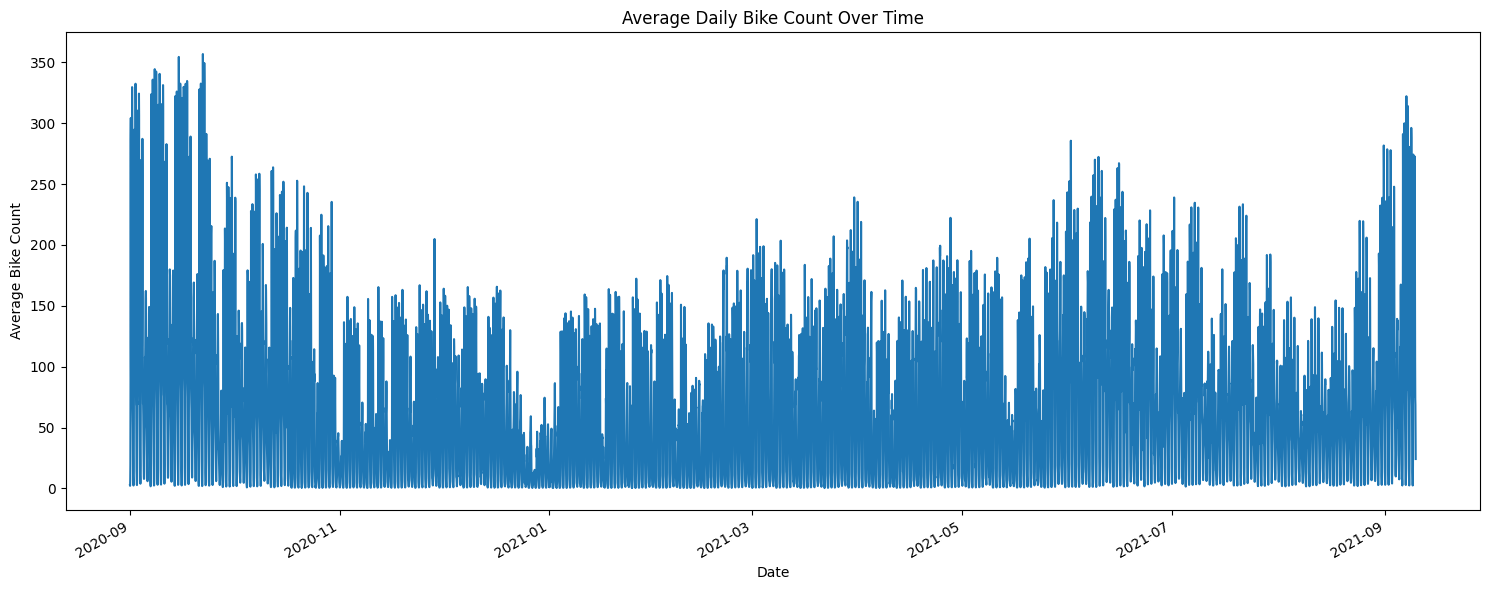

In [61]:

# Time Series View
plt.figure(figsize=(15, 6))
daily_counts = df.groupby('date')['bike_count'].mean()
daily_counts.plot()
plt.title('Average Daily Bike Count Over Time')
plt.xlabel('Date')
plt.ylabel('Average Bike Count')
plt.tight_layout()
plt.show()


This seems to confirm my view, for example we can look at around end of decemeber most people are in vacation, it's cold and there is a sharp drop in velib use...

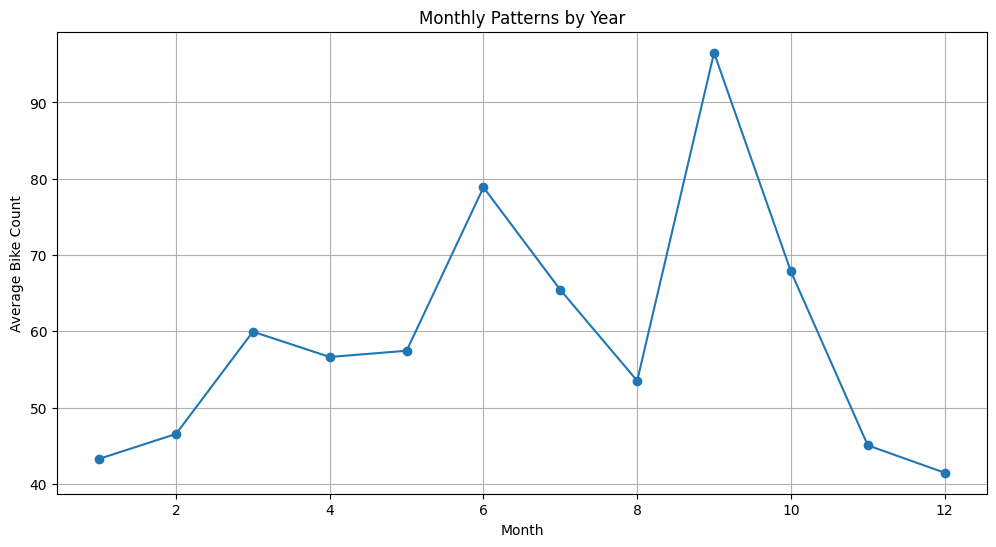

In [62]:
# Monthly patterns
monthly_traffic = df.groupby(['month'])['bike_count'].mean()
plt.figure(figsize=(12, 6))
monthly_traffic.T.plot(marker='o')
plt.title('Monthly Patterns by Year')
plt.xlabel('Month')
plt.ylabel('Average Bike Count')
plt.grid(True)
plt.show()


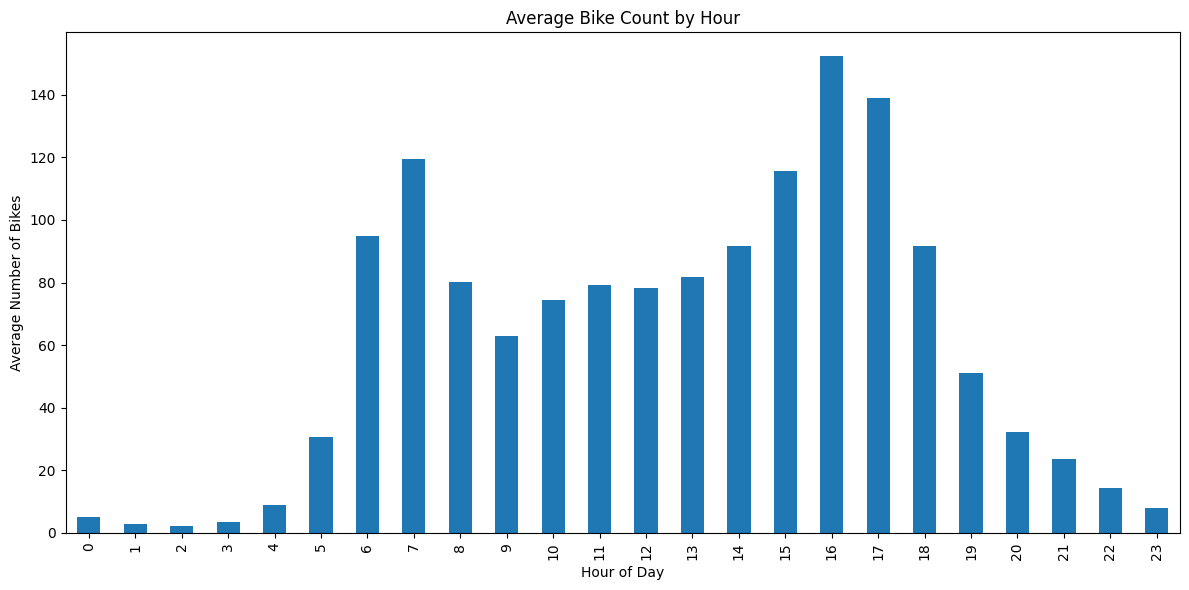

In [63]:
# Plot hourly patterns
plt.figure(figsize=(12, 6))
hourly_avg = df.groupby('hour')['bike_count'].mean()
hourly_avg.plot(kind='bar')
plt.title('Average Bike Count by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Number of Bikes')
plt.tight_layout()
plt.show()

Velib are used for commuting to working  looking at the peak hours. Let's verify that by looking at weekdays/weekends and weekdays/holidays patterns an important difference will indicate different use.

<Figure size 1200x600 with 0 Axes>

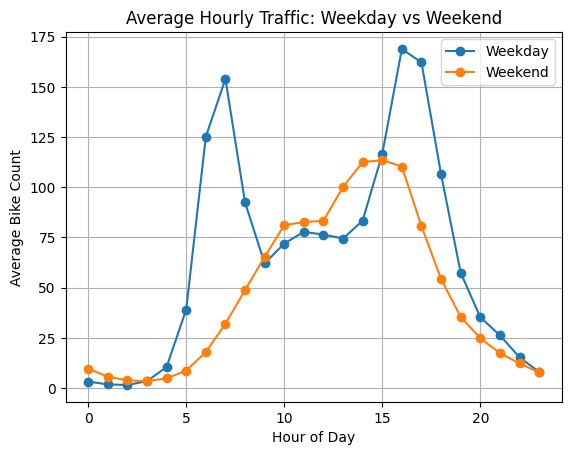

In [64]:
# Daily Patterns
hourly_traffic = df.groupby(['hour', 'is_weekend'])['bike_count'].mean().unstack()
plt.figure(figsize=(12, 6))
hourly_traffic.plot(marker='o')
plt.title('Average Hourly Traffic: Weekday vs Weekend')
plt.xlabel('Hour of Day')
plt.ylabel('Average Bike Count')
plt.legend(['Weekday', 'Weekend'])
plt.grid(True)
plt.show()

In [15]:
holidays = pd.read_csv('external_data/Holidays/Propre_jours_feries.csv')
holidays['date'] = pd.to_datetime(holidays['date'])
holidays.dtypes

date    datetime64[ns]
dtype: object

In [68]:
df['is_holiday'] = df['date'].dt.date.isin(holidays['date'].dt.date)

<Figure size 1500x600 with 0 Axes>

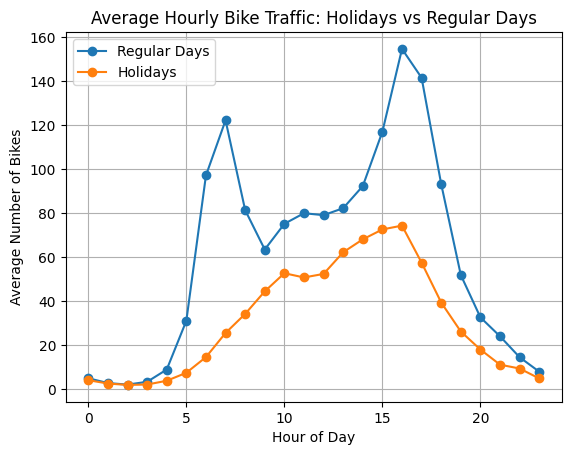

In [69]:
# Compare traffic patterns
plt.figure(figsize=(15, 6))
comparison = df.groupby(['hour', 'is_holiday'])['bike_count'].mean().unstack()
comparison.plot(marker='o')
plt.title('Average Hourly Bike Traffic: Holidays vs Regular Days')
plt.xlabel('Hour of Day')
plt.ylabel('Average Number of Bikes')
plt.legend(['Regular Days', 'Holidays'])
plt.grid(True)
plt.show()

The difference is even more important than with weekdays vs weekends.

In [70]:
# Read the holidays data
holidays_sco = pd.read_csv('external_data/Holidays/Propre_vacances_scolaires.csv')
holidays_sco.head()

date
0  2017-10-20
1  2017-10-21
2  2017-10-22
3  2017-10-23
4  2017-10-24

In [71]:
holidays_sco['date'] = pd.to_datetime(holidays_sco['date'])
df['is_holiday_sco'] = df['date'].dt.date.isin(holidays_sco['date'].dt.date)

In [72]:
holidays_sco = holidays_sco[holidays_sco['date'].dt.year == 2021]
holidays_sco = holidays_sco.drop_duplicates()
len(holidays_sco)

133

<Figure size 1500x600 with 0 Axes>

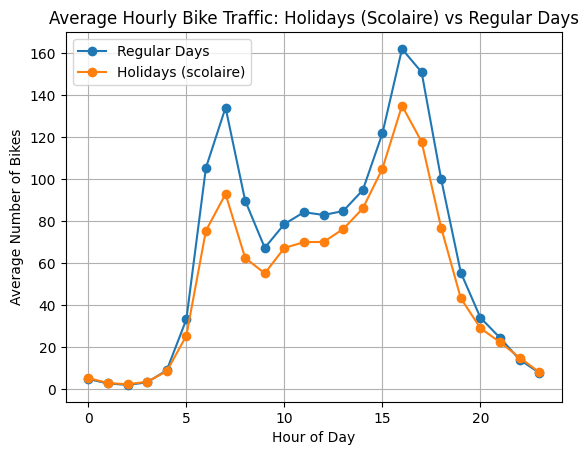

In [73]:
# 2. Compare traffic patterns vacances scolaires vs not vacances scolaires
plt.figure(figsize=(15, 6))
comparison = df.groupby(['hour', 'is_holiday_sco'])['bike_count'].mean().unstack()
comparison.plot(marker='o')
plt.title('Average Hourly Bike Traffic: Holidays (Scolaire) vs Regular Days')
plt.xlabel('Hour of Day')
plt.ylabel('Average Number of Bikes')
plt.legend(['Regular Days', 'Holidays (scolaire)'])
plt.grid(True)
plt.show()

The impact is less pronounced for holidays_sco than for bank holidays, indeed french childrens have quite a lot of holiday and adults don't always take their holidays at the same time (and have less). The information still seems to hold value so we will use it in our models.

We are considering using Cosine transformation to my data to better capture cyclical patterns. This is the analysis obtained (I decided not too keep the code because we will be dropping the use of most of these features)

We tried this encoding and checked its correlation with log_bikes

 Add cyclical encoding for hour (24-hour cycle)
- df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
- df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)

 Add cyclical encoding for month (12-month cycle)
- df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
- df['month_cos'] = np.cos(2 * np.pi * df['month']/12)

Add cyclical encoding for day_of_week (7-day cycle)
- df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week']/7)
- df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week']/7)

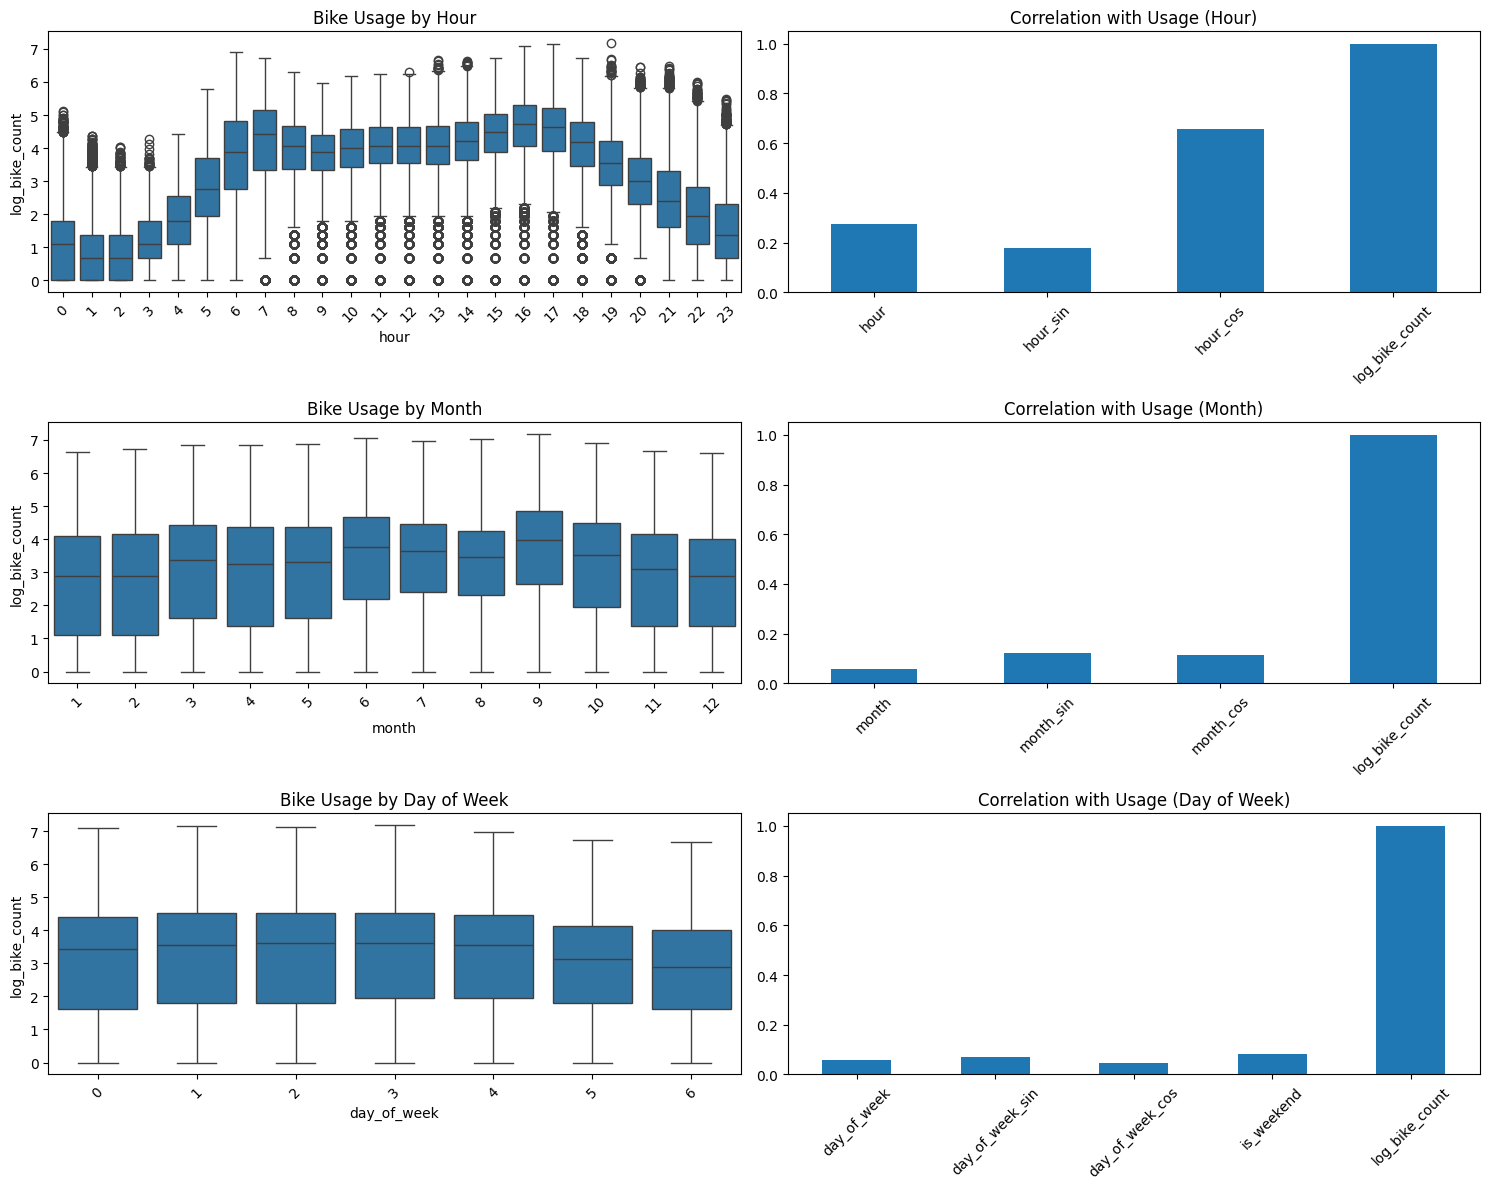

1. Let's keep:
- For the hour, let's replace the raw hour by the cos and sin transformation (high correlation). Keeping only one would make loose directionality
- For themonth, let's replace the raw month by the cos and sin transformation (high correlation). Keeping only one would make loose directionality
- For the day of the week, let's keep the raw data to avoid feature inflation

In [75]:
df

counter_id                counter_name    site_id  \
48321   100007049-102007049    28 boulevard Diderot E-O  100007049   
48324   100007049-102007049    28 boulevard Diderot E-O  100007049   
48327   100007049-102007049    28 boulevard Diderot E-O  100007049   
48330   100007049-102007049    28 boulevard Diderot E-O  100007049   
48333   100007049-102007049    28 boulevard Diderot E-O  100007049   
...                     ...                         ...        ...   
929175  300014702-353245971  254 rue de Vaugirard SO-NE  300014702   
929178  300014702-353245971  254 rue de Vaugirard SO-NE  300014702   
929181  300014702-353245971  254 rue de Vaugirard SO-NE  300014702   
929184  300014702-353245971  254 rue de Vaugirard SO-NE  300014702   
929187  300014702-353245971  254 rue de Vaugirard SO-NE  300014702   

                   site_name  bike_count                date  \
48321   28 boulevard Diderot         0.0 2020-09-01 02:00:00   
48324   28 boulevard Diderot         1.0 2020-09-01 03:00:00   
48327   28 boulevard Diderot         0.0 2020-09-01 04:00:00   
48330   28 boulevard Diderot         4.0 2020-09-01 15:00:00   
48333   28 boulevard Diderot         9.0 2020-09-01 18:00:00   
...                      ...         ...                 ...   
929175  254 rue de Vaugirard       445.0 2021-09-09 06:00:00   
929178  254 rue de Vaugirard       145.0 2021-09-09 10:00:00   
929181  254 rue de Vaugirard       218.0 2021-09-09 15:00:00   
929184  254 rue de Vaugirard        21.0 2021-09-09 22:00:00   
929187  254 rue de Vaugirard        15.0 2021-09-09 23:00:00   

       counter_installation_date         coordinates counter_technical_id  \
48321                 2013-01-18  48.846028,2.375429          Y2H15027244   
48324                 2013-01-18  48.846028,2.375429          Y2H15027244   
48327                 2013-01-18  48.846028,2.375429          Y2H15027244   
48330                 2013-01-18  48.846028,2.375429          Y2H15027244   
48333                 2013-01-18  48.846028,2.375429          Y2H15027244   
...                          ...                 ...                  ...   
929175                2020-11-29    48.83977,2.30198          Y2H20114504   
929178                2020-11-29    48.83977,2.30198          Y2H20114504   
929181                2020-11-29    48.83977,2.30198          Y2H20114504   
929184                2020-11-29    48.83977,2.30198          Y2H20114504   
929187                2020-11-29    48.83977,2.30198          Y2H20114504   

         latitude  longitude  log_bike_count  hour  day_of_week  month  \
48321   48.846028   2.375429        0.000000     2            1      9   
48324   48.846028   2.375429        0.693147     3            1      9   
48327   48.846028   2.375429        0.000000     4            1      9   
48330   48.846028   2.375429        1.609438    15            1      9   
48333   48.846028   2.375429        2.302585    18            1      9   
...           ...        ...             ...   ...          ...    ...   
929175  48.839770   2.301980        6.100319     6            3      9   
929178  48.839770   2.301980        4.983607    10            3      9   
929181  48.839770   2.301980        5.389072    15            3      9   
929184  48.839770   2.301980        3.091042    22            3      9   
929187  48.839770   2.301980        2.772589    23            3      9   

         weekday  is_weekend  is_holiday  is_holiday_sco  
48321    Tuesday       False       False           False  
48324    Tuesday       False       False           False  
48327    Tuesday       False       False           False  
48330    Tuesday       False       False           False  
48333    Tuesday       False       False           False  
...          ...         ...         ...             ...  
929175  Thursday       False       False           False  
929178  Thursday       False       False           False  
929181  Thursday       False       False           False  
929

In [24]:
df.head()

counter_id              counter_name    site_id  \
48321  100007049-102007049  28 boulevard Diderot E-O  100007049   
48324  100007049-102007049  28 boulevard Diderot E-O  100007049   
48327  100007049-102007049  28 boulevard Diderot E-O  100007049   
48330  100007049-102007049  28 boulevard Diderot E-O  100007049   
48333  100007049-102007049  28 boulevard Diderot E-O  100007049   

                  site_name  bike_count                date  \
48321  28 boulevard Diderot         0.0 2020-09-01 02:00:00   
48324  28 boulevard Diderot         1.0 2020-09-01 03:00:00   
48327  28 boulevard Diderot         0.0 2020-09-01 04:00:00   
48330  28 boulevard Diderot         4.0 2020-09-01 15:00:00   
48333  28 boulevard Diderot         9.0 2020-09-01 18:00:00   

      counter_installation_date         coordinates counter_technical_id  \
48321                2013-01-18  48.846028,2.375429          Y2H15027244   
48324                2013-01-18  48.846028,2.375429          Y2H15027244   
48327                2013-01-18  48.846028,2.375429          Y2H15027244   
48330                2013-01-18  48.846028,2.375429          Y2H15027244   
48333                2013-01-18  48.846028,2.375429          Y2H15027244   

        latitude  longitude  log_bike_count  
48321  48.846028   2.375429        0.000000  
48324  48.846028   2.375429        0.693147  
48327  48.846028   2.375429        0.000000  
48330  48.846028   2.375429        1.609438  
48333  48.846028   2.375429        2.302585

In [3]:
def create_engineered_features(df):
    """Create optimized feature set based on correlation analysis"""
    df = df.copy()

    #Import holidays data
    holidays = pd.read_csv('external_data/Holidays/Propre_jours_feries.csv')
    holidays_sco = pd.read_csv('external_data/Holidays/Propre_vacances_scolaires.csv')

    #Define holidays columns and holidays_sco
    holidays['date'] = pd.to_datetime(holidays['date'])
    df['is_holiday'] = df['date'].dt.date.isin(holidays['date'].dt.date)
    holidays_sco['date'] = pd.to_datetime(holidays_sco['date'])
    df['is_holiday_sco'] = df['date'].dt.date.isin(holidays_sco['date'].dt.date)

    # Convert date to datetime
    df['date'] = pd.to_datetime(df['date'])
    df['hour'] = df['date'].dt.hour
    df['month'] = df['date'].dt.month
    df['weekday'] = df['date'].dt.day_name()
    df['is_weekend'] = df['date'].dt.weekday >= 5

    # Keep only hour cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
    df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12)

    # Create working day feature
    df['is_working_day'] = (~df['is_weekend']) & (~df['is_holiday'])
    # Create rush hour feature (only for working days)
    morning_rush = (df['hour'].between(7, 9)) & df['is_working_day']
    evening_rush = (df['hour'].between(16, 18)) & df['is_working_day']
    # Add rush hour binary feature
    df['is_rush_hour'] = (morning_rush | evening_rush).astype(bool)

    # Drop useless columns
    df = df.drop(columns='hour')
    df = df.drop(columns='month')
    df = df.drop(columns=['counter_id', 'site_id', 'site_name', 'bike_count',
       'date', 'counter_installation_date', 'coordinates',
       'counter_technical_id'])


    # Define feature groups
    numeric_features = [
        'latitude',
        'longitude',
        'hour_sin',
        'hour_cos',
        'month_sin',
        'month_cos'
    ]

    binary_features = [
        'is_weekend',
        'is_holiday',
        'is_holiday_sco',
        'is_working_day',
        'is_rush_hour'
    ]

    categorical_features = ['counter_name', 'weekday']

    target = ['log_bike_count']

    reordered_columns = numeric_features + binary_features + categorical_features + target
    df = df.reindex(columns=reordered_columns)


    return df, numeric_features, binary_features, categorical_features

In [4]:
final_df, numeric_features, binary_features, categorical_features = create_engineered_features(df)
final_df.head()

latitude  longitude  hour_sin      hour_cos  month_sin     month_cos  \
48321  48.846028   2.375429  0.500000  8.660254e-01       -1.0 -1.836970e-16   
48324  48.846028   2.375429  0.707107  7.071068e-01       -1.0 -1.836970e-16   
48327  48.846028   2.375429  0.866025  5.000000e-01       -1.0 -1.836970e-16   
48330  48.846028   2.375429 -0.707107 -7.071068e-01       -1.0 -1.836970e-16   
48333  48.846028   2.375429 -1.000000 -1.836970e-16       -1.0 -1.836970e-16   

       is_weekend  is_holiday  is_holiday_sco  is_working_day  is_rush_hour  \
48321       False       False           False            True         False   
48324       False       False           False            True         False   
48327       False       False           False            True         False   
48330       False       False           False            True         False   
48333       False       False           False            True          True   

                   counter_name  weekday  log_bike_count  
48321  28 boulevard Diderot E-O  Tuesday        0.000000  
48324  28 boulevard Diderot E-O  Tuesday        0.693147  
48327  28 boulevard Diderot E-O  Tuesday        0.000000  
48330  28 boulevard Diderot E-O  Tuesday        1.609438  
48333  28 boulevard Diderot E-O  Tuesday        2.302585

In [17]:
X = final_df[numeric_features + binary_features + categorical_features]
y = final_df['log_bike_count']

In [1]:
correlation_matrix = final_df[final_numerical_features].corr()
# Créer la heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap de la matrice de corrélation')
plt.show()

NameError: name 'final_df' is not defined

In [ ]:
def prepare_data(df):
    # Apply feature engineering
    transformed_df, num_feat, bin_feat, cat_feat = create_engineered_features(df)

    # Split features and target
    X = transformed_df.drop(columns=['log_bike_count'])
    y = transformed_df['log_bike_count']

    return X, y, num_feat, bin_feat, cat_feat

In [ ]:
def get_pipeline(numeric_features, binary_features, categorical_features):
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numeric_features),
        ('bin', 'passthrough', binary_features),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
    ])

    return Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', Ridge())
    ])

In [41]:
X, y, num_feat, bin_feat, cat_feat = prepare_data(df)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tscv = TimeSeriesSplit(n_splits=2, test_size=24*7)  # 1 week test size
pipeline = get_pipeline(num_feat, bin_feat, cat_feat)

grid_search = GridSearchCV(
    pipeline,
    {
        'regressor__alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
        'regressor__fit_intercept': [True],
    },
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

In [42]:

grid_search.fit(X_train, y_train)

# Print results
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {-grid_search.best_score_:.4f}")

results_df = pd.DataFrame(grid_search.cv_results_)
print("\nTop 5 parameter combinations:")
top_results = results_df.sort_values('mean_test_score', ascending=False).head()
for _, row in top_results.iterrows():
    print(f"\nScore: {-row['mean_test_score']:.4f} (+/- {row['std_test_score']:.4f})")
    print("Parameters:", {k.replace('regressor__', ''): v for k, v in row['params'].items()})

# Test score
test_score = grid_search.score(X_test, y_test)
print(f"\nTest set score: {-test_score:.4f}")

Fitting 2 folds for each of 5 candidates, totalling 10 fits
Best parameters: {'regressor__alpha': 100.0, 'regressor__fit_intercept': True}
Best score: 0.9366

Top 5 parameter combinations:

Score: 0.9366 (+/- 0.0258)
Parameters: {'alpha': 100.0, 'fit_intercept': True}

Score: 0.9368 (+/- 0.0255)
Parameters: {'alpha': 10.0, 'fit_intercept': True}

Score: 0.9368 (+/- 0.0254)
Parameters: {'alpha': 1.0, 'fit_intercept': True}

Score: 0.9368 (+/- 0.0254)
Parameters: {'alpha': 0.1, 'fit_intercept': True}

Score: 0.9368 (+/- 0.0254)
Parameters: {'alpha': 0.01, 'fit_intercept': True}

Test set score: 0.8968


RMSE of Ridge is quite high with this pipeline.

In [44]:
final_df.dtypes

latitude           float64
longitude          float64
hour_sin           float64
hour_cos           float64
month_sin          float64
month_cos          float64
is_weekend            bool
is_holiday            bool
is_holiday_sco        bool
is_working_day        bool
is_rush_hour          bool
counter_name      category
weekday             object
log_bike_count     float64
dtype: object

In [48]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer


X = final_df[numeric_features + categorical_features + binary_features]
y = final_df['log_bike_count']

class BikePredictor:
    def __init__(self):
        self.numeric_features = [
            'latitude',
            'longitude',
            'hour_sin',
            'hour_cos',
            'month_sin',
            'month_cos'
        ]

        self.binary_features = [
            'is_weekend',
            'is_holiday',
            'is_holiday_sco',
            'is_working_day',
            'is_rush_hour'
        ]

        self.categorical_features = [
            'counter_name',
            'weekday'
        ]

    def create_pipeline(self):
        # Add polynomial features for numeric variables
        numeric_transformer = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ])

        categorical_transformer = Pipeline(steps=[
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ])

        preprocessor = ColumnTransformer(transformers=[
            ('num', numeric_transformer, self.numeric_features),
            ('cat', categorical_transformer, self.categorical_features),
            ('bin', 'passthrough', self.binary_features)
        ])

        return Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', Ridge())
        ])

    def grid_search(self, X, y):
        # Expanded parameter grid
        param_grid = {
            'regressor__alpha': [1.0, 10.0, 100.0],
            'preprocessor__num__poly__degree': [1, 2]  # Try with and without polynomial features
        }

        # Time series split with more folds
        tscv = TimeSeriesSplit(n_splits=5, gap=24)  # gap of 24 hours

        # Create grid search
        grid_search = GridSearchCV(
            estimator=self.create_pipeline(),
            param_grid=param_grid,
            cv=tscv,
            scoring={
                'rmse': 'neg_root_mean_squared_error',
                'r2': 'r2'
            },
            refit='rmse',
            n_jobs=-1,
            verbose=1
        )

        # Fit grid search
        grid_search.fit(X, y)

        return grid_search

    def analyze_errors(self, model, X, y):
        """Analyze prediction errors to understand model weaknesses"""
        y_pred = model.predict(X)
        errors = y - y_pred

        error_analysis = pd.DataFrame({
            'true': y,
            'predicted': y_pred,
            'error': errors,
            'abs_error': np.abs(errors),
            'hour': X['hour'] if 'hour' in X.columns else None,
            'is_weekend': X['is_weekend'] if 'is_weekend' in X.columns else None
        })

        # Aggregate errors by different conditions
        analysis = {
            'overall_rmse': np.sqrt(np.mean(errors**2)),
            'weekend_rmse': error_analysis[error_analysis['is_weekend']]['abs_error'].mean(),
            'weekday_rmse': error_analysis[~error_analysis['is_weekend']]['abs_error'].mean(),
        }

        return analysis, error_analysis

predictor = BikePredictor()

# Perform grid search
grid_search = predictor.grid_search(X, y)

# Get best model
best_model = grid_search.best_estimator_

# Analyze errors
error_analysis, error_df = predictor.analyze_errors(best_model, X, y)

print("\nError Analysis:")
for metric, value in error_analysis.items():
    print(f"{metric}: {value:.4f}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits

Error Analysis:
overall_rmse: 0.7904
weekend_rmse: 0.6087
weekday_rmse: 0.5717


In [49]:
grid_search.best_params_

{'preprocessor__num__poly__degree': 2, 'regressor__alpha': 1.0}

Looking at these error analysis results, let's interpret and make improvements:

The overall RMSE has improved to 0.7904 (better than previous 1.1585)
Weekend errors (0.6236) are slightly higher than weekday errors (0.5717)


From "Forecasting Bike Rental Demand" by Du et al., they found that hourly patterns have "clear variation between work days and weekends" and "certain hours (peak hours) will clearly have significantly more bike rentals than other hours."
From "A predictive analytics approach for forecasting bike rental demand" (Karunanithi et al.), analysis showed distinct usage patterns:

Weekday peak hours: 7-9 am and 5-7 pm showed heavy usage (commuting patterns)
Weekend peak hours: 10 am - 6 pm showed different patterns
Total rentals during peak hours comprised 28.19% of all rentals

The main arguments for separate models are:
Different Behaviors:
Peak hours are dominated by commuter patterns
Off-peak hours follow leisure/tourism patterns
Different features might be important at different times

## Let's try implement an AutoML

I need to one-hot-encode all my categorical data first

## Without using AutoML, doing it iteratively

In [ ]:
# Liste des modèles de régression à tester
regressors = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Decision Tree": DecisionTreeRegressor(),
    #"Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    #"Support Vector Regressor": SVR(),
}

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)

# Split the dataset
X = final_df[numeric_features + binary_features + categorical_features]
y = final_df['log_bike_count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Preprocess the data
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
X_train_processed = pipeline.fit_transform(X_train)
X_test_processed = pipeline.transform(X_test)

# Pour stocker les résultats
results = []

# Test des modèles
for name, model in regressors.items():
    # Entraîner le modèle
    model.fit(X_train_processed, y_train)
    
    # Faire des prédictions
    y_pred = model.predict(X_test_processed)
    
    # Évaluer les performances
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Stocker les résultats
    results.append({
        "Model": name,
        "Mean Squared Error": mse,
        "R^2 Score": r2
    })

    print(f'The result for {name} is a Mean Squared Error of {mse} and a r2 of {r2}')

# Afficher les résultats
results_df = pd.DataFrame(results)
print(results_df)

The result for Linear Regression is a Mean Squared Error of 0.8075070586721532 and a r2 of 0.7071730172139519
The result for Ridge Regression is a Mean Squared Error of 0.807519687674131 and a r2 of 0.7071684375480467
The result for Lasso Regression is a Mean Squared Error of 2.572610238733198 and a r2 of 0.06709212507504769
The result for Decision Tree is a Mean Squared Error of 0.3223312091370826 and a r2 of 0.8831127549713325
The result for Gradient Boosting is a Mean Squared Error of 0.523688323855543 and a r2 of 0.8100944503852797


In [17]:
# Dictionary of regression models
regressors = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(), 
    "Lasso Regression": Lasso(),   
    "ElasticNet Regression": ElasticNet(),
}

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'  # Pass binary features as they are
)

# Train-test split
X = final_df[numeric_features + binary_features + categorical_features]
y = final_df['log_bike_count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Store results
results = {}

# Iterate over models
for name, model in regressors.items():
    print(f"Training {name}...")
    
    # Define pipeline for each model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    # Cross-validation
    scores = cross_val_score(pipeline, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
    rmse_scores = np.sqrt(-scores)
    
    # Fit and evaluate
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Store results
    results[name] = {
        'CV RMSE Mean': rmse_scores.mean(),
        'CV RMSE Std': rmse_scores.std(),
        'Test RMSE': test_rmse
    }

Training Linear Regression...
Training Ridge Regression...
Training Lasso Regression...
Training ElasticNet Regression...


In [18]:
# Display results
results_df = pd.DataFrame(results).T
results_df.sort_values(by='Test RMSE', ascending=True, inplace=True)
results_df.head()

CV RMSE Mean  CV RMSE Std  Test RMSE
Linear Regression          0.900562     0.002521   0.898614
Ridge Regression           0.900572     0.002519   0.898621
ElasticNet Regression      1.433389     0.001286   1.433814
Lasso Regression           1.603119     0.001820   1.603936

In [5]:
# Dictionary of regression models
regressors = {
    #"Random Forest Regressor": RandomForestRegressor(), Trop long
    #Support Vector Regressor": SVR(),  Trop long
    "MLP Regressor": MLPRegressor(),   
}

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'  # Pass binary features as they are
)

# Train-test split
X = final_df[numeric_features + binary_features + categorical_features]
y = final_df['log_bike_count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Store results
results = {}

# Iterate over models
for name, model in regressors.items():
    print(f"Training {name}...")
    
    # Define pipeline for each model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    # Cross-validation
    scores = cross_val_score(pipeline, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
    rmse_scores = np.sqrt(-scores)
    
    # Fit and evaluate
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Store results
    results[name] = {
        'CV RMSE Mean': rmse_scores.mean(),
        'CV RMSE Std': rmse_scores.std(),
        'Test RMSE': test_rmse
    }

Training MLP Regressor...


In [6]:
# Display results
results_df = pd.DataFrame(results).T
results_df.sort_values(by='Test RMSE', ascending=True, inplace=True)
results_df.head()

CV RMSE Mean  CV RMSE Std  Test RMSE
MLP Regressor      0.463184     0.002485   0.456582

## For our best models, let's try tune the hyperparameters

In [8]:
import optuna

In [12]:
# Define the regressor and its hyperparameter search space
regressor_name = "CatBoost Regressor"
regressor = CatBoostRegressor(verbose=0)
hyperparams = {
    "iterations": lambda trial: trial.suggest_int('iterations', 100, 500),  # Reduced range
    "learning_rate": lambda trial: trial.suggest_float('learning_rate', 1e-5, 1e0, log=True),  # Reduced range
    "depth": lambda trial: trial.suggest_int('depth', 4, 8),  # Reduced range
    "l2_leaf_reg": lambda trial: trial.suggest_float('l2_leaf_reg', 1e-8, 1e0, log=True),  # Reduced range
    "bagging_temperature": lambda trial: trial.suggest_float('bagging_temperature', 1e-8, 1e0, log=True),  # Reduced range
    "random_strength": lambda trial: trial.suggest_float('random_strength', 1e-9, 10, log=True),  # Reduced range
    "border_count": lambda trial: trial.suggest_int('border_count', 32, 128),  # Reduced range
    "od_type": lambda trial: trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
    "od_wait": lambda trial: trial.suggest_int('od_wait', 10, 30)  # Reduced range
}

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'  # Pass binary features as they are
)

# Train-test split
X = final_df[numeric_features + binary_features + categorical_features]
y = final_df['log_bike_count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Use a smaller subset of the data for tuning
subset_size = 0.4  # Use 40% of the data
X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, train_size=subset_size, random_state=1)

def objective(trial):
    model = regressor
    for param_name, param_func in hyperparams.items():
        model.set_params(**{param_name: param_func(trial)})

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    scores = cross_val_score(pipeline, X_train_subset, y_train_subset, scoring='neg_mean_squared_error', cv=5)
    rmse_scores = np.sqrt(-scores)
    return rmse_scores.mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, n_jobs=-1)  # Use all available CPUs

# Best trial
best_trial = study.best_trial
best_params = {k: v for k, v in best_trial.params.items()}

print(f"Best model: {regressor_name}")
print(f"Best hyperparameters: {best_params}")
print(f"CV RMSE Mean: {best_trial.value}")

# Train the best model with the best hyperparameters
best_model = regressor
best_model.set_params(**best_params)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', best_model)
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Test RMSE: {test_rmse}")

[I 2024-12-05 14:37:27,582] A new study created in memory with name: no-name-09be40a1-e04d-4e40-be7a-cfc68e01eed8
[I 2024-12-05 14:40:24,908] Trial 1 finished with value: 1.5062024359897095 and parameters: {'iterations': 419, 'learning_rate': 0.4749863142215847, 'depth': 8, 'l2_leaf_reg': 4.971001427873396e-05, 'bagging_temperature': 3.684488982452505e-05, 'random_strength': 0.001433823651740722, 'border_count': 48, 'od_type': 'Iter', 'od_wait': 26}. Best is trial 1 with value: 1.5062024359897095.
[I 2024-12-05 14:40:28,224] Trial 2 finished with value: 1.5062024359897095 and parameters: {'iterations': 435, 'learning_rate': 0.027561995208688874, 'depth': 4, 'l2_leaf_reg': 0.026110232657424605, 'bagging_temperature': 0.0012361099876360708, 'random_strength': 0.004084550046882928, 'border_count': 98, 'od_type': 'Iter', 'od_wait': 14}. Best is trial 1 with value: 1.5062024359897095.
[I 2024-12-05 14:40:28,240] Trial 3 finished with value: 1.5062024359897095 and parameters: {'iterations': 

Best model: CatBoost Regressor
Best hyperparameters: {'iterations': 469, 'learning_rate': 0.2360288221321401, 'depth': 8, 'l2_leaf_reg': 0.0779639925192747, 'bagging_temperature': 0.44999874921003585, 'random_strength': 1.0463493738896407e-09, 'border_count': 115, 'od_type': 'IncToDec', 'od_wait': 26}
CV RMSE Mean: 0.4491932102491953
Test RMSE: 0.4353546343537906


In [13]:
# Extract the trials and convert to DataFrame
trials_df = study.trials_dataframe()

# Sort the DataFrame by the objective value
trials_df_sorted = trials_df.sort_values(by='value')

# Display the sorted DataFrame
trials_df_sorted.head(20)

number     value             datetime_start          datetime_complete  \
86      86  0.449193 2024-12-05 16:01:49.339279 2024-12-05 16:08:04.638402   
87      87  0.449369 2024-12-05 16:01:52.756593 2024-12-05 16:07:59.958669   
85      85  0.449609 2024-12-05 16:00:43.059179 2024-12-05 16:07:00.212031   
84      84  0.449609 2024-12-05 16:00:41.296392 2024-12-05 16:07:00.158900   
76      76  0.449632 2024-12-05 15:48:57.120001 2024-12-05 15:54:49.391462   
63      63  0.451436 2024-12-05 15:26:45.082128 2024-12-05 15:33:16.553333   
95      95  0.451635 2024-12-05 16:13:55.330467 2024-12-05 16:19:37.745436   
94      94  0.451635 2024-12-05 16:13:55.103787 2024-12-05 16:19:37.695997   
62      62  0.451674 2024-12-05 15:26:45.006829 2024-12-05 15:33:05.472892   
96      96  0.452797 2024-12-05 16:18:23.636773 2024-12-05 16:24:38.237953   
97      97  0.452921 2024-12-05 16:18:27.194763 2024-12-05 16:24:38.194209   
79      79  0.453528 2024-12-05 15:50:09.215029 2024-12-05 15:55:54.722608   
98      98  0.453787 2024-12-05 16:19:37.713465 2024-12-05 16:25:15.393672   
99      99  0.453787 2024-12-05 16:19:37.773017 2024-12-05 16:25:10.424321   
75      75  0.454214 2024-12-05 15:44:53.600375 2024-12-05 15:50:06.631054   
74      74  0.454214 2024-12-05 15:44:53.262068 2024-12-05 15:50:09.215029   
60      60  0.454322 2024-12-05 15:26:14.558881 2024-12-05 15:32:02.234593   
61      61  0.454322 2024-12-05 15:26:14.579598 2024-12-05 15:32:06.371322   
82      82  0.457264 2024-12-05 15:55:53.292919 2024-12-05 16:01:49.330156   
83      83  0.457646 2024-12-05 15:55:54.738227 2024-12-05 16:01:52.742434   

                 duration  params_bagging_temperature  params_border_count  \
86 0 days 00:06:15.299123                    0.449999                  115   
87 0 days 00:06:07.202076                    0.009273                  125   
85 0 days 00:06:17.152852                    0.431026                   55   
84 0 days 00:06:18.862508                    0.223811                   52   
76 0 days 00:05:52.271461                    0.000075                  123   
63 0 days 00:06:31.471205                    0.016858                  128   
95 0 days 00:05:42.414969                    0.063416                   50   
94 0 days 00:05:42.592210                    0.081005                   53   
62 0 days 00:06:20.466063                    0.000374                  101   
96 0 days 00:06:14.601180                    0.913527                   49   
97 0 days 00:06:10.999446                    0.938274                   38   
79 0 days 00:05:45.507579                    0.275776                  123   
98 0 days 00:05:37.680207                    0.096531                   62   
99 0 days 00:05:32.651304                    0.067517                   58   
75 0 days 00:05:13.030679                    0.002823                  123   
74 0 days 00:05:15.952961                    0.212916                  116   
60 0 days 00:05:47.675712                    0.000021                  124   
61 0 days 00:05:51.791724                    0.000025                  128   
82 0 days 00:05:56.037237                    0.014345                  118   
83 0 days 00:05:58.004207                    0.153030                  116   

    params_depth  params_iterations  params_l2_leaf_reg  params_learning_rate  \
86             8                469            0.077964              0.236029   
87             8                473            0.081841              0.233748   
85             8                461            0.078487              0.206682   
84             8                469            0.038772              0.137107   
76             8                460            0.031153              0.227992   
63             7                500            0.016494              0.280668   
95             8                439            0.080451              0.182718   
94             8                446            0.069775              0.184691 

In [15]:
# Save the sorted DataFrame to a CSV file
trials_df_sorted.to_csv('optuna_CatBoost_trials_sorted.csv', index=False)